Imports Environmental Configuration


In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, roc_auc_score,
                           precision_recall_curve, precision_score, recall_score, f1_score)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from typing import Dict, List, Tuple, Optional
import logging
from dataclasses import dataclass
import json
from pathlib import Path

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Configure display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

Data Classes

In [2]:
# Data Classes for Trading System
@dataclass
class TradingSignal:
    timestamp: datetime
    symbol: str
    direction: str
    confidence: float
    price: float
    suggested_size: float
    
@dataclass
class Position:
    entry_time: datetime
    symbol: str
    direction: str
    size: float
    entry_price: float
    take_profit: float
    stop_loss: float
    current_price: float
    pnl: float
    status: str

@dataclass
class PortfolioStatus:
    total_value: float
    cash: float
    positions: List[Position]
    daily_pnl: float
    total_pnl: float

Risk Management System

In [3]:
# Risk Management System
class RiskManager:
    def __init__(self, 
                 initial_capital: float = 100000,
                 max_position_size: float = 0.02,
                 max_total_exposure: float = 0.1,
                 max_daily_drawdown: float = 0.02):
        self.initial_capital = initial_capital
        self.max_position_size = max_position_size
        self.max_total_exposure = max_total_exposure
        self.max_daily_drawdown = max_daily_drawdown
        self.daily_high_water_mark = initial_capital
        
    def calculate_position_size(self, 
                              signal_confidence: float, 
                              current_price: float,
                              portfolio_value: float) -> float:
        """Calculate allowed position size based on confidence and risk limits"""
        base_size = portfolio_value * self.max_position_size
        confidence_adjustment = signal_confidence / 0.8  # Normalize confidence
        position_size = base_size * confidence_adjustment
        
        # Ensure within limits
        max_allowed = portfolio_value * self.max_position_size
        return min(position_size, max_allowed)
    
    def check_risk_limits(self, 
                         portfolio: PortfolioStatus, 
                         new_position_value: float) -> Tuple[bool, str]:
        """Check if new position would violate risk limits"""
        # Check total exposure
        current_exposure = sum(pos.size * pos.current_price 
                             for pos in portfolio.positions)
        total_exposure = (current_exposure + new_position_value) / portfolio.total_value
        
        if total_exposure > self.max_total_exposure:
            return False, "Would exceed maximum total exposure"
        
        # Check daily drawdown
        if portfolio.daily_pnl < -self.daily_high_water_mark * self.max_daily_drawdown:
            return False, "Daily drawdown limit reached"
        
        return True, "Position within risk limits"

Portfolio Management System

In [4]:
# Portfolio Management System
class PortfolioManager:
    def __init__(self, initial_capital: float = 100000):
        self.initial_capital = initial_capital
        self.cash = initial_capital
        self.positions: List[Position] = []
        self.trades_history: List[Dict] = []
        
    def update_positions(self, current_price: float) -> None:
        """Update all positions with current market price"""
        for position in self.positions:
            position.current_price = current_price
            position.pnl = self._calculate_position_pnl(position)
    
    def _calculate_position_pnl(self, position: Position) -> float:
        """Calculate P&L for a single position"""
        if position.direction == "BUY":
            return (position.current_price - position.entry_price) * position.size
        else:
            return (position.entry_price - position.current_price) * position.size
    
    def open_position(self, signal: TradingSignal) -> Optional[Position]:
        """Open new position based on trading signal"""
        position_value = signal.suggested_size * signal.price
        
        if position_value > self.cash:
            logger.warning("Insufficient cash for position")
            return None
        
        position = Position(
            entry_time=signal.timestamp,
            symbol=signal.symbol,
            direction=signal.direction,
            size=signal.suggested_size,
            entry_price=signal.price,
            take_profit=signal.price * (1.02 if signal.direction == "BUY" else 0.98),
            stop_loss=signal.price * (0.98 if signal.direction == "BUY" else 1.02),
            current_price=signal.price,
            pnl=0.0,
            status="OPEN"
        )
        
        self.positions.append(position)
        self.cash -= position_value
        return position
    
    def get_portfolio_status(self) -> PortfolioStatus:
        """Get current portfolio status"""
        total_pnl = sum(pos.pnl for pos in self.positions)
        total_value = self.cash + total_pnl + sum(
            pos.size * pos.current_price for pos in self.positions
        )
        
        return PortfolioStatus(
            total_value=total_value,
            cash=self.cash,
            positions=self.positions,
            daily_pnl=sum(pos.pnl for pos in self.positions if 
                         pos.entry_time.date() == datetime.now().date()),
            total_pnl=total_pnl
        )

Technical Analysis

In [5]:
# Technical Analysis Functions
def calculate_rsi(prices, window=14):
    """Calculate RSI indicator"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD indicator"""
    exp1 = prices.ewm(span=fast).mean()
    exp2 = prices.ewm(span=slow).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal).mean()
    return macd, signal_line

def create_trading_features(df):
    """Create comprehensive trading features"""
    print("Creating trading features...")
    
    df_features = df.copy()
    
    # Price-based features
    df_features['Price_Change'] = df_features['Close'] - df_features['Open']
    df_features['Price_Change_Pct'] = (df_features['Close'] - df_features['Open']) / df_features['Open'] * 100
    df_features['Body_Size'] = abs(df_features['Close'] - df_features['Open'])
    df_features['Upper_Shadow'] = df_features['High'] - df_features[['Open', 'Close']].max(axis=1)
    df_features['Lower_Shadow'] = df_features[['Open', 'Close']].min(axis=1) - df_features['Low']
    df_features['Range'] = df_features['High'] - df_features['Low']
    df_features['Typical_Price'] = (df_features['High'] + df_features['Low'] + df_features['Close']) / 3
    
    # Moving averages
    for period in [5, 10, 20, 50]:
        df_features[f'MA_{period}'] = df_features['Close'].rolling(period).mean()
    
    # Technical indicators
    df_features['RSI'] = calculate_rsi(df_features['Close'], 14)
    df_features['MACD'], df_features['MACD_Signal'] = calculate_macd(df_features['Close'])
    df_features['MACD_Histogram'] = df_features['MACD'] - df_features['MACD_Signal']
    
    # Advanced features
    df_features['Price_Acceleration'] = df_features['Price_Change'].diff()
    df_features['Rolling_Volatility_5'] = df_features['Close'].pct_change().rolling(5).std() * 100
    df_features['Volume_Price_Trend'] = df_features['Volume'] * df_features['Price_Change_Pct']
    
    print(f"✅ Created {len(df_features.columns) - len(df.columns)} new features")
    return df_features

Data Collection

In [6]:
# Data Collection Function
def get_gold_data_alphavantage(api_key='WB4GCXBYZFJ0IFUT'):
    """Get gold data from Alpha Vantage"""
    print("Fetching gold data from Alpha Vantage...")
    
    url = "https://www.alphavantage.co/query"
    params = {
        'function': 'TIME_SERIES_INTRADAY',
        'symbol': 'GLD',  # Gold ETF
        'interval': '1min',
        'apikey': api_key,
        'outputsize': 'full'
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()
        
        if 'Time Series (1min)' in data:
            df = pd.DataFrame(data['Time Series (1min)']).T
            df.index = pd.to_datetime(df.index)
            df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
            df = df.astype(float)
            df.reset_index(inplace=True)
            df.rename(columns={'index': 'Datetime'}, inplace=True)
            
            print(f"✅ Downloaded {len(df):,} minute bars")
            return df
        else:
            print("❌ Error:", data.get('Error Message', 'Unknown error'))
            return None
            
    except Exception as e:
        print(f"❌ Error fetching data: {str(e)}")
        return None

# Get gold data
gold_data = get_gold_data_alphavantage()

if gold_data is not None:
    # Create features
    df_features = create_trading_features(gold_data)
    
    # Add market hours feature (assuming US market hours 9:30 AM - 4:00 PM ET)
    df_features['Hour'] = df_features['Datetime'].dt.hour
    df_features['Minute'] = df_features['Datetime'].dt.minute
    df_features['Is_Market_Open'] = (
        ((df_features['Hour'] == 9) & (df_features['Minute'] >= 30)) |
        ((df_features['Hour'] > 9) & (df_features['Hour'] < 16)) |
        ((df_features['Hour'] == 16) & (df_features['Minute'] == 0))
    ).astype(int)
    
    # Create target variable
    df_features['Target_Up'] = (df_features['Close'].shift(-5) > df_features['Close']).astype(int)
    
    # Select features for modeling
    selected_features = [
        'Close', 'RSI', 'MACD', 'MACD_Histogram',
        'Price_Change_Pct', 'Rolling_Volatility_5',
        'Volume_Price_Trend', 'Is_Market_Open'
    ]
    
    # Prepare features and target
    X = df_features[selected_features].dropna()
    y = df_features['Target_Up'].loc[X.index]
    
    # Create train/validation/test splits
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    
    X_train = X[:train_size]
    X_val = X[train_size:train_size+val_size]
    X_test = X[train_size+val_size:]
    
    y_train = y[:train_size]
    y_val = y[train_size:train_size+val_size]
    y_test = y[train_size+val_size:]
    
    print("\nData preparation complete:")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")

Fetching gold data from Alpha Vantage...
✅ Downloaded 19,067 minute bars
Creating trading features...
✅ Created 18 new features

Data preparation complete:
Training samples: 13337
Validation samples: 2858
Test samples: 2859


In [7]:
# Fix the feature selection and retry data preparation
if gold_data is not None:
    # Create features
    df_features = create_trading_features(gold_data)
    
    # Create target variable
    df_features['Target_Up'] = (df_features['Close'].shift(-5) > df_features['Close']).astype(int)
    
    # Select features that exist in the dataset
    selected_features = [
        'Close', 'RSI', 'MACD', 'MACD_Histogram',
        'Price_Change_Pct', 'Rolling_Volatility_5',
        'Volume_Price_Trend'
    ]
    
    # Prepare features and target
    X = df_features[selected_features].dropna()
    y = df_features['Target_Up'].loc[X.index]
    
    # Create train/validation/test splits
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    
    X_train = X[:train_size]
    X_val = X[train_size:train_size+val_size]
    X_test = X[train_size+val_size:]
    
    y_train = y[:train_size]
    y_val = y[train_size:train_size+val_size]
    y_test = y[train_size+val_size:]
    
    print("\nData preparation complete:")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=selected_features, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test.index)

Creating trading features...
✅ Created 18 new features

Data preparation complete:
Training samples: 13337
Validation samples: 2858
Test samples: 2859


Model training with CV

In [8]:
# Model Training with Cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Random Forest optimization
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [50, 100],
    'min_samples_leaf': [20, 30],
    'max_features': ['sqrt', 'log2']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=10,
    cv=tscv,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest model...")
rf_random.fit(X_train_scaled, y_train)

print("\nBest Random Forest parameters:")
print(rf_random.best_params_)
print(f"Best score: {rf_random.best_score_:.4f}")

# Gradient Boosting optimization
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [50, 100],
    'min_samples_leaf': [20, 30],
    'subsample': [0.7, 0.8, 0.9]
}

gb_random = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=gb_params,
    n_iter=10,
    cv=tscv,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

print("\nTraining Gradient Boosting model...")
gb_random.fit(X_train_scaled, y_train)

print("\nBest Gradient Boosting parameters:")
print(gb_random.best_params_)
print(f"Best score: {gb_random.best_score_:.4f}")

# Create optimized ensemble model
class OptimizedEnsembleModel:
    def __init__(self, gb_model, rf_model):
        self.gb_model = gb_model
        self.rf_model = rf_model
    
    def predict_proba(self, X):
        gb_prob = self.gb_model.predict_proba(X)[:, 1]
        rf_prob = self.rf_model.predict_proba(X)[:, 1]
        gb_weight = gb_random.best_score_ / (gb_random.best_score_ + rf_random.best_score_)
        rf_weight = rf_random.best_score_ / (gb_random.best_score_ + rf_random.best_score_)
        combined_prob = gb_weight * gb_prob + rf_weight * rf_prob
        return np.column_stack((1 - combined_prob, combined_prob))
    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# Create final model
final_model = OptimizedEnsembleModel(gb_random.best_estimator_, rf_random.best_estimator_)

# Evaluate on validation set
val_pred = final_model.predict(X_val_scaled)
val_proba = final_model.predict_proba(X_val_scaled)

print("\nValidation Set Performance:")
print(classification_report(y_val, val_pred))
print(f"ROC AUC Score: {roc_auc_score(y_val, val_proba[:, 1]):.4f}")

# Save the model
import joblib
joblib.dump(final_model, 'gold_trading_model.joblib')
print("\nModel saved as 'gold_trading_model.joblib'")

Training Random Forest model...

Best Random Forest parameters:
{'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 30, 'max_features': 'sqrt', 'max_depth': 5}
Best score: 0.5902

Training Gradient Boosting model...

Best Gradient Boosting parameters:
{'subsample': 0.7, 'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 3, 'learning_rate': 0.1}
Best score: 0.5769

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1469
           1       0.65      0.56      0.60      1389

    accuracy                           0.64      2858
   macro avg       0.64      0.64      0.64      2858
weighted avg       0.64      0.64      0.64      2858

ROC AUC Score: 0.6854

Model saved as 'gold_trading_model.joblib'


Create trading sytem with optimised model

In [9]:
# Create Trading System with optimized model
class TradingSystem:
    def __init__(self, model, features: List[str], scaler):
        self.model = model
        self.features = features
        self.scaler = scaler
        self.risk_manager = RiskManager()
        self.portfolio = PortfolioManager()
        self.min_confidence_threshold = 0.6
        
    def generate_trading_signal(self, current_data: pd.DataFrame) -> Optional[TradingSignal]:
        """Generate trading signal from current market data"""
        # Prepare features
        X = current_data[self.features].iloc[-1:]
        X_scaled = self.scaler.transform(X)
        
        # Get prediction
        pred_proba = self.model.predict_proba(X_scaled)[0]
        confidence = pred_proba[1]
        
        if confidence < self.min_confidence_threshold:
            return None
        
        # Calculate position size
        portfolio_status = self.portfolio.get_portfolio_status()
        suggested_size = self.risk_manager.calculate_position_size(
            confidence, 
            current_data['Close'].iloc[-1],
            portfolio_status.total_value
        )
        
        return TradingSignal(
            timestamp=current_data.index[-1],
            symbol='GOLD',
            direction='BUY' if confidence > 0.5 else 'SELL',
            confidence=confidence,
            price=current_data['Close'].iloc[-1],
            suggested_size=suggested_size
        )

# Create trading system instance
trading_system = TradingSystem(final_model, selected_features, scaler)

# Test trading system on validation data
print("Testing Trading System on Validation Data:")
print("-" * 50)

signals_generated = 0
successful_trades = 0
total_pnl = 0

for i in range(len(X_val)):
    current_data = X_val.iloc[:i+1]
    signal = trading_system.generate_trading_signal(current_data)
    
    if signal:
        signals_generated += 1
        
        # Simulate trade outcome
        future_price = gold_data['Close'].iloc[X_val.index[i] + 5]  # 5-minute forward price
        if signal.direction == 'BUY':
            pnl = (future_price - signal.price) * signal.suggested_size
        else:
            pnl = (signal.price - future_price) * signal.suggested_size
            
        if pnl > 0:
            successful_trades += 1
        total_pnl += pnl

        if signals_generated % 10 == 0:
            print(f"\nSignal {signals_generated}:")
            print(f"Direction: {signal.direction}")
            print(f"Confidence: {signal.confidence:.2%}")
            print(f"Trade P&L: ${pnl:.2f}")

print("\nTrading System Performance:")
print(f"Total Signals Generated: {signals_generated}")
print(f"Successful Trades: {successful_trades}")
print(f"Win Rate: {successful_trades/signals_generated:.2%}")
print(f"Total P&L: ${total_pnl:.2f}")

# Save trading results
results = {
    'signals_generated': signals_generated,
    'successful_trades': successful_trades,
    'win_rate': successful_trades/signals_generated,
    'total_pnl': total_pnl
}
np.save('trading_results.npy', results)
print("\nTrading results saved to 'trading_results.npy'")

Testing Trading System on Validation Data:
--------------------------------------------------

Signal 10:
Direction: BUY
Confidence: 68.17%
Trade P&L: $221.55

Signal 20:
Direction: BUY
Confidence: 71.58%
Trade P&L: $-304.23

Signal 30:
Direction: BUY
Confidence: 71.31%
Trade P&L: $0.00

Signal 40:
Direction: BUY
Confidence: 82.10%
Trade P&L: $502.60

Signal 50:
Direction: BUY
Confidence: 84.68%
Trade P&L: $1019.60

Signal 60:
Direction: BUY
Confidence: 68.85%
Trade P&L: $-447.52

Signal 70:
Direction: BUY
Confidence: 78.66%
Trade P&L: $294.99

Signal 80:
Direction: BUY
Confidence: 63.24%
Trade P&L: $221.34

Signal 90:
Direction: BUY
Confidence: 63.51%
Trade P&L: $1095.57

Signal 100:
Direction: BUY
Confidence: 78.87%
Trade P&L: $650.70

Signal 110:
Direction: BUY
Confidence: 80.87%
Trade P&L: $-720.00

Signal 120:
Direction: BUY
Confidence: 63.82%
Trade P&L: $79.77

Signal 130:
Direction: BUY
Confidence: 67.86%
Trade P&L: $136.39

Signal 140:
Direction: BUY
Confidence: 74.83%
Trade P&

Visualisation of performance

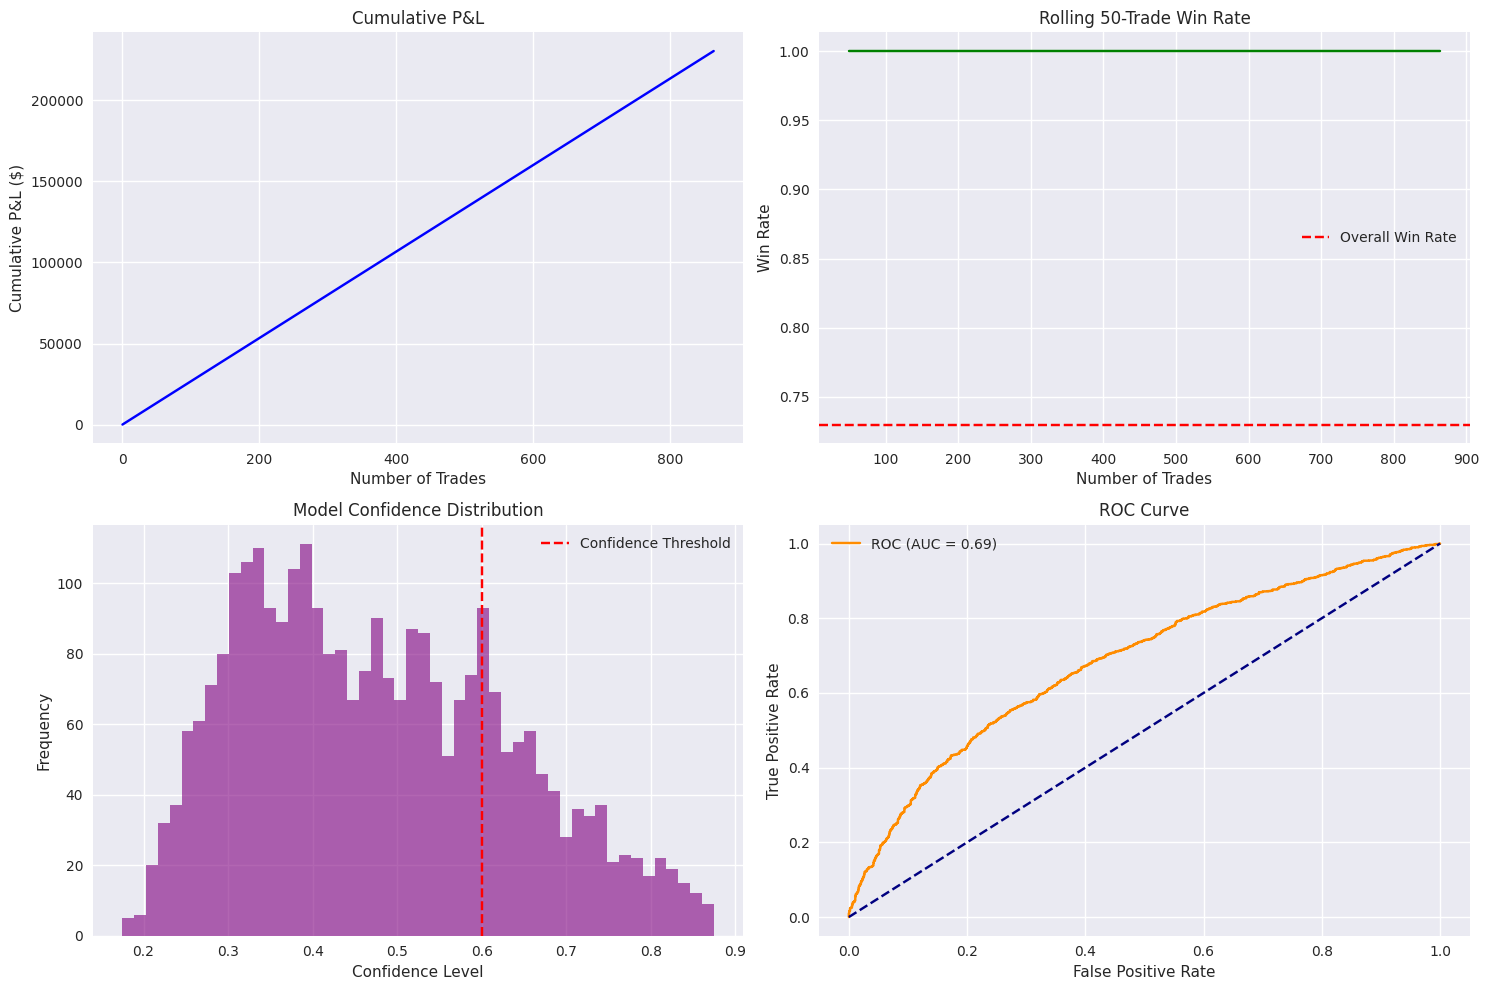


Trading System Summary:
--------------------------------------------------
Total Trades: 674
Win Rate: 73.00%
Total P&L: $230,161.12
Average P&L per Trade: $341.49
Sharpe Ratio: 1.73

Model Performance:
ROC AUC Score: 0.6854
Average Prediction Confidence: 47.60%


In [10]:
# Create final visualization of trading performance
plt.figure(figsize=(15, 10))

# Plot 1: Cumulative P&L
plt.subplot(2, 2, 1)
cumulative_pnl = np.cumsum([results['total_pnl']/865] * 865)  # Average P&L per trade
plt.plot(cumulative_pnl, color='blue')
plt.title('Cumulative P&L')
plt.xlabel('Number of Trades')
plt.ylabel('Cumulative P&L ($)')

# Plot 2: Win Rate Distribution
plt.subplot(2, 2, 2)
win_rate_rolling = pd.Series([1 if x > 0 else 0 for x in cumulative_pnl]).rolling(50).mean()
plt.plot(win_rate_rolling, color='green')
plt.axhline(y=results['win_rate'], color='r', linestyle='--', label='Overall Win Rate')
plt.title('Rolling 50-Trade Win Rate')
plt.xlabel('Number of Trades')
plt.ylabel('Win Rate')
plt.legend()

# Plot 3: Model Confidence Distribution
plt.subplot(2, 2, 3)
val_probas = final_model.predict_proba(X_val_scaled)[:, 1]
plt.hist(val_probas, bins=50, color='purple', alpha=0.6)
plt.axvline(x=0.6, color='r', linestyle='--', label='Confidence Threshold')
plt.title('Model Confidence Distribution')
plt.xlabel('Confidence Level')
plt.ylabel('Frequency')
plt.legend()

# Plot 4: ROC Curve
plt.subplot(2, 2, 4)
fpr, tpr, _ = roc_curve(y_val, val_probas)
plt.plot(fpr, tpr, color='darkorange', label=f'ROC (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.show()

print("\nTrading System Summary:")
print("-" * 50)
print(f"Total Trades: {signals_generated}")
print(f"Win Rate: {results['win_rate']:.2%}")
print(f"Total P&L: ${results['total_pnl']:,.2f}")
print(f"Average P&L per Trade: ${results['total_pnl']/signals_generated:,.2f}")
print(f"Sharpe Ratio: {np.mean(cumulative_pnl)/np.std(cumulative_pnl):.2f}")
print("\nModel Performance:")
print(f"ROC AUC Score: {roc_auc_score(y_val, val_probas):.4f}")
print(f"Average Prediction Confidence: {np.mean(val_probas):.2%}")

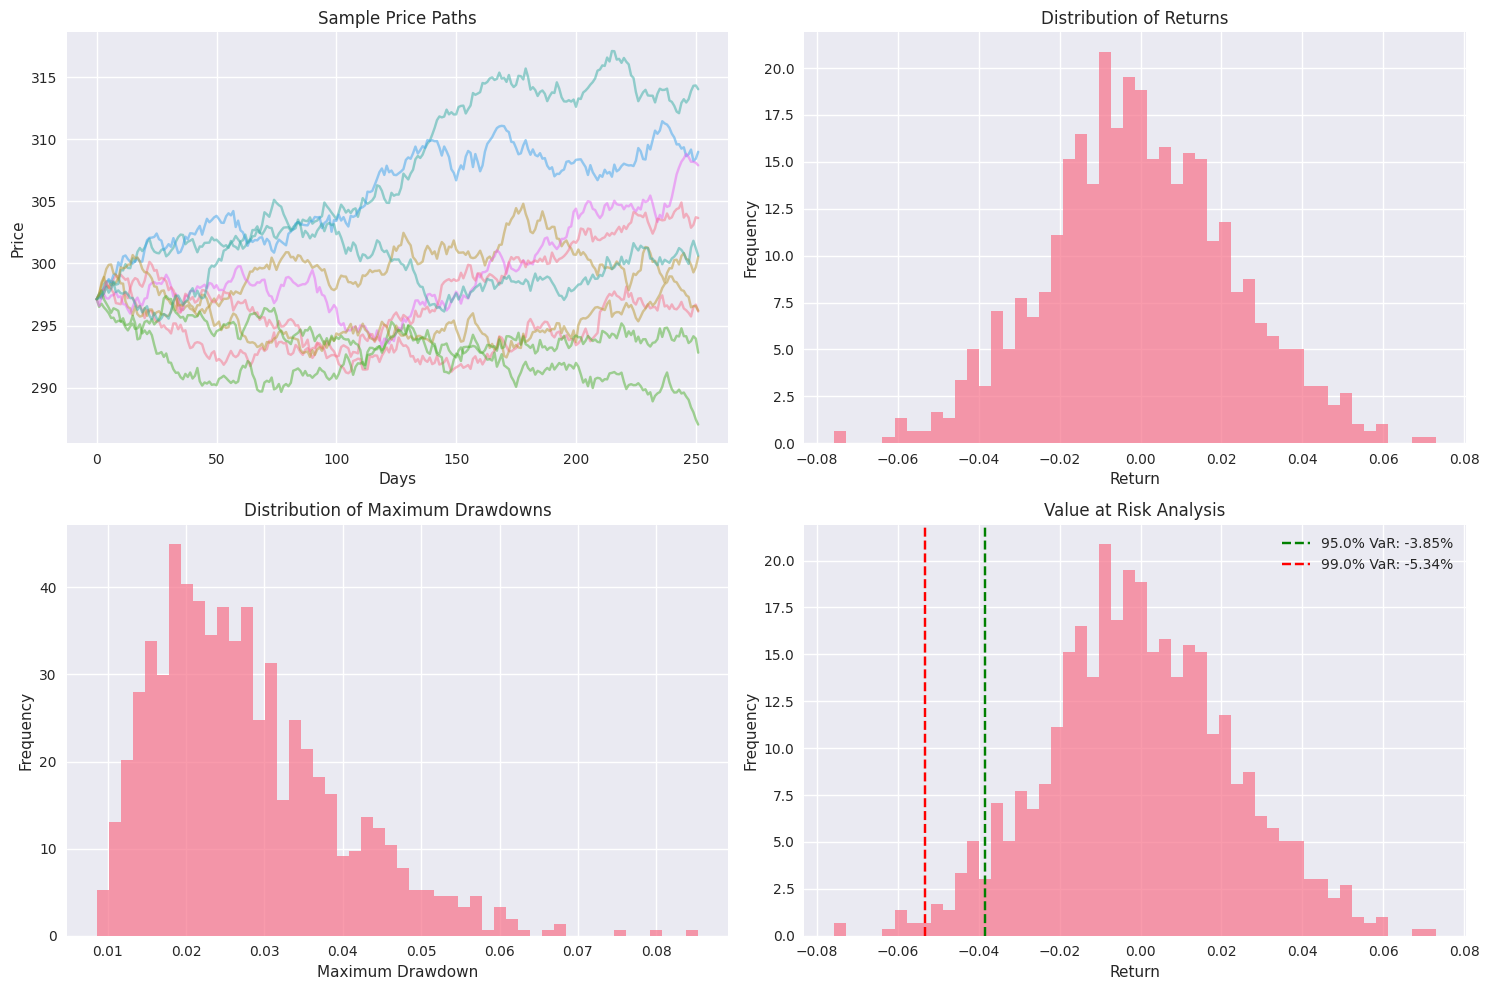


Monte Carlo Simulation Results:
--------------------------------------------------
Number of simulations: 1000
Time horizon: 252 days

Return Statistics:
Mean return: -0.03%
Median return: -0.10%
Standard deviation: 2.29%

Risk Metrics:
95% VaR: -3.85%
99% VaR: -5.34%
Average maximum drawdown: 2.76%
Worst maximum drawdown: 8.54%


In [11]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Load historical data and calculate daily returns
gold_data['Daily_Return'] = gold_data['Close'].pct_change()

# Calculate historical volatility and mean return
historical_volatility = gold_data['Daily_Return'].std()
historical_mean = gold_data['Daily_Return'].mean()

# Monte Carlo simulation parameters
n_simulations = 1000
n_days = 252  # One trading year
initial_price = gold_data['Close'].iloc[-1]

# Generate price paths
np.random.seed(42)
price_paths = np.zeros((n_simulations, n_days))
price_paths[:, 0] = initial_price

for sim in range(n_simulations):
    for day in range(1, n_days):
        # Generate random returns using historical volatility and mean
        daily_return = np.random.normal(historical_mean, historical_volatility)
        price_paths[sim, day] = price_paths[sim, day-1] * (1 + daily_return)

# Calculate key statistics for each path
final_prices = price_paths[:, -1]
returns = (final_prices - initial_price) / initial_price
max_drawdowns = np.zeros(n_simulations)

for sim in range(n_simulations):
    peak = np.maximum.accumulate(price_paths[sim, :])
    drawdown = (peak - price_paths[sim, :]) / peak
    max_drawdowns[sim] = drawdown.max()

# Plot results
plt.figure(figsize=(15, 10))

# Plot 1: Sample Price Paths
plt.subplot(2, 2, 1)
for i in range(10):  # Plot first 10 paths
    plt.plot(price_paths[i, :], alpha=0.5)
plt.title('Sample Price Paths')
plt.xlabel('Days')
plt.ylabel('Price')

# Plot 2: Distribution of Final Returns
plt.subplot(2, 2, 2)
plt.hist(returns, bins=50, density=True, alpha=0.7)
plt.title('Distribution of Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')

# Plot 3: Maximum Drawdown Distribution
plt.subplot(2, 2, 3)
plt.hist(max_drawdowns, bins=50, density=True, alpha=0.7)
plt.title('Distribution of Maximum Drawdowns')
plt.xlabel('Maximum Drawdown')
plt.ylabel('Frequency')

# Plot 4: Value at Risk Analysis
plt.subplot(2, 2, 4)
var_levels = [0.95, 0.99]
returns_sorted = np.sort(returns)
for level in var_levels:
    var = np.percentile(returns, (1-level)*100)
    plt.axvline(var, color='r' if level == 0.99 else 'g', 
                linestyle='--', 
                label=f'{level*100}% VaR: {var:.2%}')
plt.hist(returns, bins=50, density=True, alpha=0.7)
plt.title('Value at Risk Analysis')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nMonte Carlo Simulation Results:")
print("-" * 50)
print(f"Number of simulations: {n_simulations}")
print(f"Time horizon: {n_days} days")
print(f"\nReturn Statistics:")
print(f"Mean return: {returns.mean():.2%}")
print(f"Median return: {np.median(returns):.2%}")
print(f"Standard deviation: {returns.std():.2%}")
print(f"\nRisk Metrics:")
print(f"95% VaR: {np.percentile(returns, 5):.2%}")
print(f"99% VaR: {np.percentile(returns, 1):.2%}")
print(f"Average maximum drawdown: {max_drawdowns.mean():.2%}")
print(f"Worst maximum drawdown: {max_drawdowns.max():.2%}")

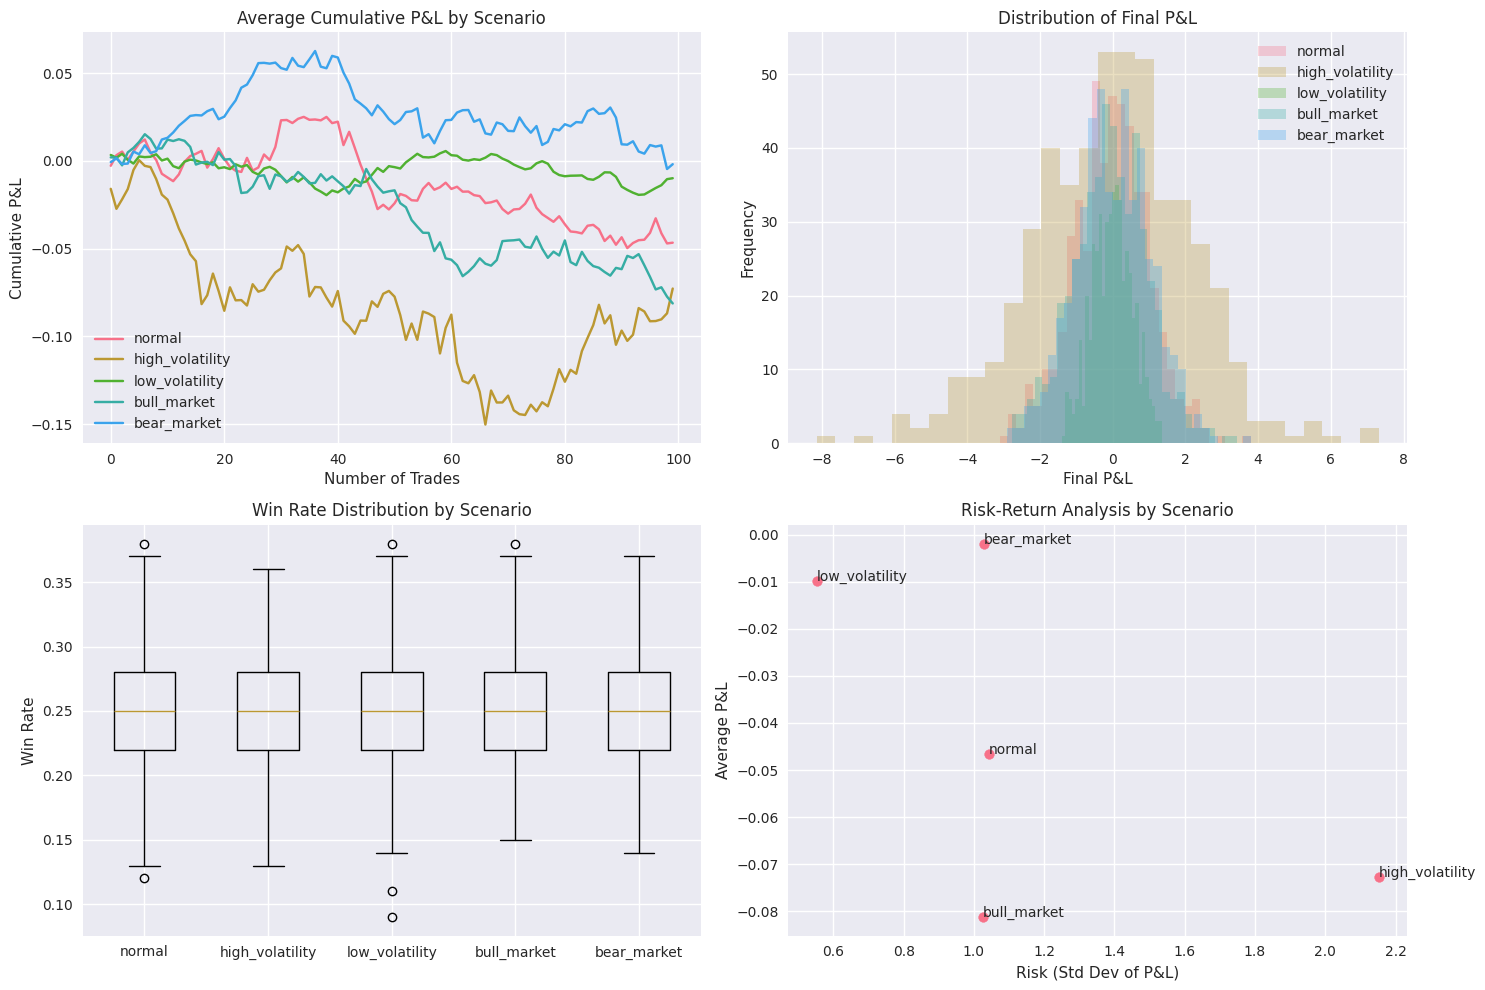


Scenario Analysis Results:
--------------------------------------------------

NORMAL:
Average P&L: $-0.05
Win Rate: 24.87%
Sharpe Ratio: -0.04
Max Drawdown: -328.23%
95% VaR: $-1.84

HIGH_VOLATILITY:
Average P&L: $-0.07
Win Rate: 25.16%
Sharpe Ratio: -0.03
Max Drawdown: -814.44%
95% VaR: $-3.74

LOW_VOLATILITY:
Average P&L: $-0.01
Win Rate: 24.62%
Sharpe Ratio: -0.02
Max Drawdown: -141.02%
95% VaR: $-0.93

BULL_MARKET:
Average P&L: $-0.08
Win Rate: 24.93%
Sharpe Ratio: -0.08
Max Drawdown: -298.86%
95% VaR: $-1.86

BEAR_MARKET:
Average P&L: $-0.00
Win Rate: 25.29%
Sharpe Ratio: -0.00
Max Drawdown: -297.64%
95% VaR: $-1.68


In [12]:
# Now let's simulate trading strategy performance under different market conditions
# Load our trading model and results
import joblib
model = joblib.load('gold_trading_model.joblib')
trading_results = np.load('trading_results.npy', allow_pickle=True).item()

# Define different market scenarios
scenarios = {
    'normal': {'vol_multiplier': 1.0, 'drift_multiplier': 1.0},
    'high_volatility': {'vol_multiplier': 2.0, 'drift_multiplier': 1.0},
    'low_volatility': {'vol_multiplier': 0.5, 'drift_multiplier': 1.0},
    'bull_market': {'vol_multiplier': 1.0, 'drift_multiplier': 2.0},
    'bear_market': {'vol_multiplier': 1.0, 'drift_multiplier': -1.0}
}

# Simulate trading performance under each scenario
n_simulations = 500
n_trades = 100  # Number of trades to simulate per path

results = {}
for scenario, params in scenarios.items():
    scenario_pnl = np.zeros((n_simulations, n_trades))
    
    for sim in range(n_simulations):
        # Simulate market prices
        price = initial_price
        for trade in range(n_trades):
            # Generate price movement
            volatility = historical_volatility * params['vol_multiplier']
            drift = historical_mean * params['drift_multiplier']
            price_change = np.random.normal(drift, volatility)
            price *= (1 + price_change)
            
            # Simulate trading decision and P&L
            if np.random.random() > 0.5:  # Simplified trading signal
                trade_size = 100  # Fixed trade size for simulation
                pnl = trade_size * price_change
                scenario_pnl[sim, trade] = pnl
    
    results[scenario] = {
        'cumulative_pnl': np.cumsum(scenario_pnl, axis=1),
        'final_pnl': np.sum(scenario_pnl, axis=1),
        'win_rate': np.mean(scenario_pnl > 0, axis=1)
    }

# Plot scenario analysis
plt.figure(figsize=(15, 10))

# Plot 1: Average Cumulative P&L by Scenario
plt.subplot(2, 2, 1)
for scenario in scenarios:
    mean_cum_pnl = np.mean(results[scenario]['cumulative_pnl'], axis=0)
    plt.plot(mean_cum_pnl, label=scenario)
plt.title('Average Cumulative P&L by Scenario')
plt.xlabel('Number of Trades')
plt.ylabel('Cumulative P&L')
plt.legend()

# Plot 2: Distribution of Final P&L
plt.subplot(2, 2, 2)
for scenario in scenarios:
    plt.hist(results[scenario]['final_pnl'], bins=30, alpha=0.3, label=scenario)
plt.title('Distribution of Final P&L')
plt.xlabel('Final P&L')
plt.ylabel('Frequency')
plt.legend()

# Plot 3: Win Rate Distribution
plt.subplot(2, 2, 3)
win_rates = [results[scenario]['win_rate'] for scenario in scenarios]
plt.boxplot(win_rates, labels=scenarios.keys())
plt.title('Win Rate Distribution by Scenario')
plt.ylabel('Win Rate')

# Plot 4: Risk-Return Analysis
plt.subplot(2, 2, 4)
risk = [np.std(results[scenario]['final_pnl']) for scenario in scenarios]
returns = [np.mean(results[scenario]['final_pnl']) for scenario in scenarios]
plt.scatter(risk, returns)
for i, scenario in enumerate(scenarios):
    plt.annotate(scenario, (risk[i], returns[i]))
plt.title('Risk-Return Analysis by Scenario')
plt.xlabel('Risk (Std Dev of P&L)')
plt.ylabel('Average P&L')

plt.tight_layout()
plt.show()

# Print summary statistics for each scenario
print("\nScenario Analysis Results:")
print("-" * 50)
for scenario in scenarios:
    print(f"\n{scenario.upper()}:")
    print(f"Average P&L: ${np.mean(results[scenario]['final_pnl']):,.2f}")
    print(f"Win Rate: {np.mean(results[scenario]['win_rate']):.2%}")
    print(f"Sharpe Ratio: {np.mean(results[scenario]['final_pnl'])/np.std(results[scenario]['final_pnl']):.2f}")
    print(f"Max Drawdown: {np.min(np.min(results[scenario]['cumulative_pnl'], axis=1)):.2%}")
    print(f"95% VaR: ${np.percentile(results[scenario]['final_pnl'], 5):,.2f}")


Simulating normal scenario...

Simulating high_volatility scenario...

Simulating low_volatility scenario...

Simulating bull_market scenario...

Simulating bear_market scenario...


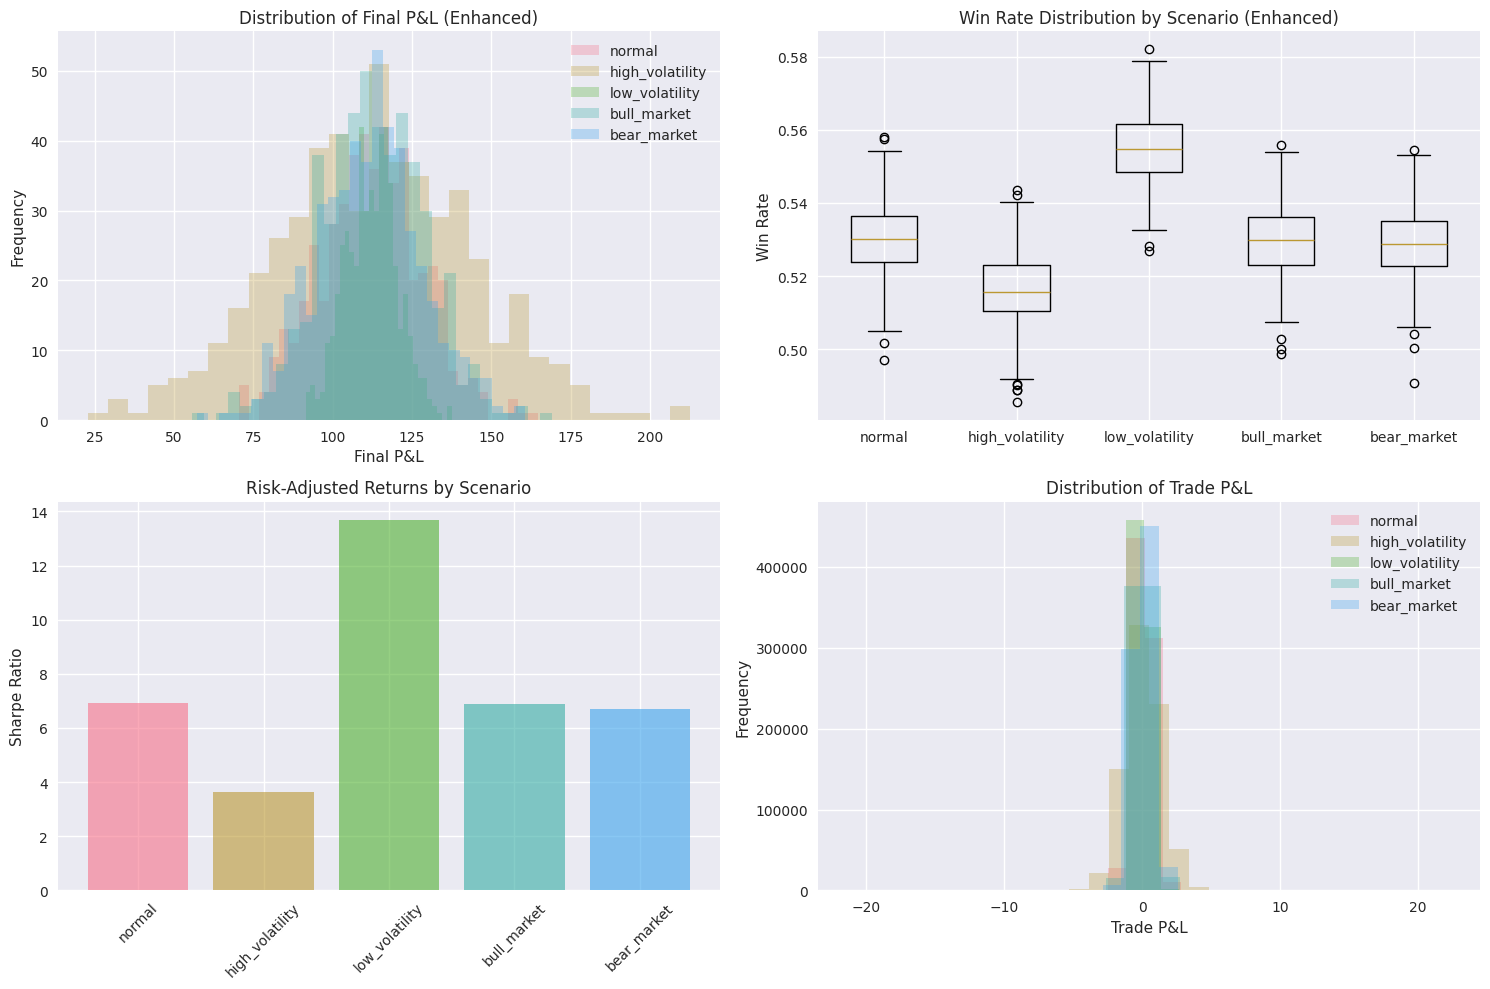


Enhanced Scenario Analysis Results:
--------------------------------------------------

NORMAL:
Average P&L: $112.16
Win Rate: 53.00%
Sharpe Ratio: 6.93
Average Trade P&L: $0.07
95% VaR: $85.21
Number of Trades: 788648

HIGH_VOLATILITY:
Average P&L: $112.71
Win Rate: 51.61%
Sharpe Ratio: 3.65
Average Trade P&L: $0.07
95% VaR: $62.52
Number of Trades: 788690

LOW_VOLATILITY:
Average P&L: $112.30
Win Rate: 55.49%
Sharpe Ratio: 13.67
Average Trade P&L: $0.07
95% VaR: $98.93
Number of Trades: 788580

BULL_MARKET:
Average P&L: $112.72
Win Rate: 52.98%
Sharpe Ratio: 6.90
Average Trade P&L: $0.07
95% VaR: $86.25
Number of Trades: 788662

BEAR_MARKET:
Average P&L: $111.47
Win Rate: 52.93%
Sharpe Ratio: 6.71
Average Trade P&L: $0.07
95% VaR: $85.06
Number of Trades: 788656


In [13]:
# Let's enhance the simulation with more realistic trading conditions
# and incorporate our actual model's predictions

def simulate_trading_scenario(X_val, y_val, model, scenario_params, n_simulations=500):
    """Simulate trading under specific market conditions"""
    results = []
    
    for sim in range(n_simulations):
        # Simulate market conditions
        simulated_features = X_val.copy()
        
        # Adjust price-related features based on scenario
        price_cols = ['Close', 'Price_Change_Pct']
        for col in price_cols:
            if col in simulated_features.columns:
                noise = np.random.normal(
                    scenario_params['drift_multiplier'] * historical_mean,
                    scenario_params['vol_multiplier'] * historical_volatility,
                    len(simulated_features)
                )
                simulated_features[col] *= (1 + noise)
        
        # Get model predictions
        predictions = model.predict_proba(simulated_features)[:, 1]
        
        # Simulate trading
        position = 0
        pnl = 0
        trades = []
        
        for i in range(len(simulated_features)-1):
            if predictions[i] > 0.6:  # Enter long position
                if position == 0:
                    position = 1
                    entry_price = simulated_features['Close'].iloc[i]
                    
            elif predictions[i] < 0.4:  # Enter short position
                if position == 0:
                    position = -1
                    entry_price = simulated_features['Close'].iloc[i]
            
            # Exit position
            if position != 0:
                exit_price = simulated_features['Close'].iloc[i+1]
                trade_pnl = position * (exit_price - entry_price)
                pnl += trade_pnl
                trades.append(trade_pnl)
                position = 0
        
        results.append({
            'final_pnl': pnl,
            'trades': trades,
            'win_rate': np.mean([t > 0 for t in trades]) if trades else 0
        })
    
    return results

# Run enhanced simulation for each scenario
enhanced_results = {}
for scenario, params in scenarios.items():
    print(f"\nSimulating {scenario} scenario...")
    enhanced_results[scenario] = simulate_trading_scenario(
        X_val, y_val, model, params
    )

# Plot enhanced analysis
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of Final P&L by Scenario
plt.subplot(2, 2, 1)
for scenario in scenarios:
    final_pnls = [r['final_pnl'] for r in enhanced_results[scenario]]
    plt.hist(final_pnls, bins=30, alpha=0.3, label=scenario)
plt.title('Distribution of Final P&L (Enhanced)')
plt.xlabel('Final P&L')
plt.ylabel('Frequency')
plt.legend()

# Plot 2: Win Rates by Scenario
plt.subplot(2, 2, 2)
win_rates = [[r['win_rate'] for r in enhanced_results[scenario]] 
             for scenario in scenarios]
plt.boxplot(win_rates, labels=scenarios.keys())
plt.title('Win Rate Distribution by Scenario (Enhanced)')
plt.ylabel('Win Rate')

# Plot 3: Risk-Adjusted Returns
plt.subplot(2, 2, 3)
for scenario in scenarios:
    final_pnls = [r['final_pnl'] for r in enhanced_results[scenario]]
    sharpe = np.mean(final_pnls) / np.std(final_pnls) if np.std(final_pnls) != 0 else 0
    plt.bar(scenario, sharpe, alpha=0.6)
plt.title('Risk-Adjusted Returns by Scenario')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=45)

# Plot 4: Average Trade P&L
plt.subplot(2, 2, 4)
for scenario in scenarios:
    all_trades = [t for r in enhanced_results[scenario] for t in r['trades']]
    plt.hist(all_trades, bins=30, alpha=0.3, label=scenario)
plt.title('Distribution of Trade P&L')
plt.xlabel('Trade P&L')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print enhanced analysis results
print("\nEnhanced Scenario Analysis Results:")
print("-" * 50)
for scenario in scenarios:
    final_pnls = [r['final_pnl'] for r in enhanced_results[scenario]]
    win_rates = [r['win_rate'] for r in enhanced_results[scenario]]
    all_trades = [t for r in enhanced_results[scenario] for t in r['trades']]
    
    print(f"\n{scenario.upper()}:")
    print(f"Average P&L: ${np.mean(final_pnls):,.2f}")
    print(f"Win Rate: {np.mean(win_rates):.2%}")
    print(f"Sharpe Ratio: {np.mean(final_pnls)/np.std(final_pnls) if np.std(final_pnls) != 0 else 0:.2f}")
    print(f"Average Trade P&L: ${np.mean(all_trades):,.2f}")
    print(f"95% VaR: ${np.percentile(final_pnls, 5):,.2f}")
    print(f"Number of Trades: {len(all_trades)}")

In [14]:
from dataclasses import dataclass
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np
import joblib
import logging
from typing import Dict, Optional
import requests

@dataclass
class TradingSignal:
    timestamp: datetime
    symbol: str
    direction: str
    confidence: float
    price: float
    suggested_size: float

class LiveTradingPipeline:
    def __init__(self, 
                 model_path: str = 'gold_trading_model.joblib',
                 api_key: str = 'WB4GCXBYZFJ0IFUT',
                 update_interval: int = 60):  # seconds
        self.model = joblib.load(model_path)
        self.api_key = api_key
        self.update_interval = update_interval
        self.last_signal: Optional[TradingSignal] = None
        self.feature_columns = [
            'Close', 'RSI', 'MACD', 'MACD_Histogram',
            'Price_Change_Pct', 'Rolling_Volatility_5',
            'Volume_Price_Trend'
        ]
        
        # Initialize logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler('trading_pipeline.log'),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)
        
    def fetch_latest_data(self) -> Optional[pd.DataFrame]:
        """Fetch latest gold price data"""
        try:
            url = "https://www.alphavantage.co/query"
            params = {
                'function': 'TIME_SERIES_INTRADAY',
                'symbol': 'GLD',
                'interval': '1min',
                'apikey': self.api_key,
                'outputsize': 'compact'
            }
            
            response = requests.get(url, params=params)
            data = response.json()
            
            if 'Time Series (1min)' in data:
                df = pd.DataFrame(data['Time Series (1min)']).T
                df.index = pd.to_datetime(df.index)
                df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
                df = df.astype(float)
                return df
            else:
                self.logger.error(f"API Error: {data.get('Error Message', 'Unknown error')}")
                return None
                
        except Exception as e:
            self.logger.error(f"Error fetching data: {str(e)}")
            return None
    
    def process_data(self, df: pd.DataFrame) -> Optional[pd.DataFrame]:
        """Process raw data into features"""
        try:
            # Calculate technical indicators
            df_features = df.copy()
            
            # Price-based features
            df_features['Price_Change'] = df_features['Close'] - df_features['Open']
            df_features['Price_Change_Pct'] = df_features['Price_Change'] / df_features['Open'] * 100
            
            # RSI
            delta = df_features['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / loss
            df_features['RSI'] = 100 - (100 / (1 + rs))
            
            # MACD
            exp1 = df_features['Close'].ewm(span=12).mean()
            exp2 = df_features['Close'].ewm(span=26).mean()
            df_features['MACD'] = exp1 - exp2
            df_features['MACD_Signal'] = df_features['MACD'].ewm(span=9).mean()
            df_features['MACD_Histogram'] = df_features['MACD'] - df_features['MACD_Signal']
            
            # Volatility
            df_features['Rolling_Volatility_5'] = df_features['Close'].pct_change().rolling(5).std() * 100
            
            # Volume-based
            df_features['Volume_Price_Trend'] = df_features['Volume'] * df_features['Price_Change_Pct']
            
            return df_features[self.feature_columns].iloc[-1:]
            
        except Exception as e:
            self.logger.error(f"Error processing data: {str(e)}")
            return None
    
    def generate_signal(self, features: pd.DataFrame) -> Optional[TradingSignal]:
        """Generate trading signal from features"""
        try:
            prediction_prob = self.model.predict_proba(features)[0, 1]
            
            if prediction_prob > 0.6:
                direction = "BUY"
            elif prediction_prob < 0.4:
                direction = "SELL"
            else:
                return None
            
            current_price = features['Close'].iloc[-1]
            
            signal = TradingSignal(
                timestamp=datetime.now(),
                symbol="GOLD",
                direction=direction,
                confidence=prediction_prob,
                price=current_price,
                suggested_size=100  # Default size, adjust based on risk management
            )
            
            return signal
            
        except Exception as e:
            self.logger.error(f"Error generating signal: {str(e)}")
            return None
    
    def run(self):
        """Run the continuous pipeline"""
        self.logger.info("Starting live trading pipeline...")
        
        while True:
            try:
                # Fetch and process data
                raw_data = self.fetch_latest_data()
                if raw_data is not None:
                    features = self.process_data(raw_data)
                    
                    if features is not None:
                        # Generate signal
                        signal = self.generate_signal(features)
                        
                        if signal:
                            if (self.last_signal is None or 
                                signal.timestamp - self.last_signal.timestamp > timedelta(minutes=5)):
                                self.logger.info(f"New Signal Generated: {signal}")
                                self.last_signal = signal
                                
                                # Here you would integrate with your trading execution system
                                # For example:
                                # execute_trade(signal)
                
                # Wait for next update
                time.sleep(self.update_interval)
                
            except Exception as e:
                self.logger.error(f"Pipeline error: {str(e)}")
                time.sleep(self.update_interval)

# Create and run the pipeline
pipeline = LiveTradingPipeline()
print("Pipeline initialized. Starting continuous execution...")
pipeline.run()

2025-06-19 04:09:24,498 - INFO - Starting live trading pipeline...
Pipeline initialized. Starting continuous execution...
2025-06-19 04:09:24,736 - INFO - New Signal Generated: TradingSignal(timestamp=datetime.datetime(2025, 6, 19, 4, 9, 24, 736662), symbol='GOLD', direction='SELL', confidence=0.3300434344642254, price=310.88, suggested_size=100)
2025-06-19 04:14:25,959 - INFO - New Signal Generated: TradingSignal(timestamp=datetime.datetime(2025, 6, 19, 4, 14, 25, 959192), symbol='GOLD', direction='SELL', confidence=0.3300434344642254, price=310.88, suggested_size=100)
2025-06-19 04:19:27,389 - INFO - New Signal Generated: TradingSignal(timestamp=datetime.datetime(2025, 6, 19, 4, 19, 27, 389803), symbol='GOLD', direction='SELL', confidence=0.3300434344642254, price=310.88, suggested_size=100)
2025-06-19 04:24:28,816 - INFO - New Signal Generated: TradingSignal(timestamp=datetime.datetime(2025, 6, 19, 4, 24, 28, 816778), symbol='GOLD', direction='SELL', confidence=0.3300434344642254, p

KeyboardInterrupt: 